In [34]:
import pandas as pd
import numpy as np
import time
import re
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf

from tf.keras.models import Sequential

from tf.keras.layers import Flatten
from tf.keras.layers import Dense
from tf.keras.layers import Embedding





from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
import nltk


#nltk.download('wordnet')
#nltk.download('omw-1.4')

#import spacy
#from nltk.corpus import stopwords

In [2]:

data=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/DataScience/ClassificationMessageTwitter/ClassificationMessageTwitter/Corona_NLP_train.csv",parse_dates=True ,encoding='latin-1')
data

data_test=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/DataScience/ClassificationMessageTwitter/ClassificationMessageTwitter/Corona_NLP_test.csv",parse_dates=True ,encoding='latin-1')
data_test.shape
data["OriginalTweet"][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

#  Data analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Les variables sont de types int et et object.
On remarque également des données manquantes dans la colonne Location.

In [4]:
is_int=list(data.select_dtypes("int64").columns)
for col in is_int:
    print(data[col].value_counts())

3799     1
31291    1
31233    1
31234    1
31235    1
        ..
17519    1
17520    1
17521    1
17522    1
44955    1
Name: UserName, Length: 41157, dtype: int64
48751    1
76243    1
76185    1
76186    1
76187    1
        ..
62471    1
62472    1
62473    1
62474    1
89907    1
Name: ScreenName, Length: 41157, dtype: int64


On remarque ScreenName et UserName sont des clefs de la dataframe. On peut donc en drop une et utiliser l'autre comme index

In [5]:
data=data.set_index("UserName")
data=data.drop("ScreenName",axis=1)
#data=data.drop("UserName",axis=1)
data

,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,
3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
3801,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3802,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...
44951,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44952,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44953,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive


Il semblerait que dans la variable location contiennent de fausses informations notamment avec des locations tels que 'vagabond' ou 'i love you so much'. Il faudrait se debarasser de ces observations.
De plus il semblerait qu'il y ait des localisations similaire orthographiées différement.

In [6]:
pd.DataFrame(data["Location"].value_counts())

,Location
London,540
United States,528
"London, England",520
"New York, NY",395
"Washington, DC",373
...,...
Staffordshire Moorlands,1
Kithchener ON,1
"Tulsa, Ok",1
"Watford, South Oxhey, Bushey",1


# Etude des données manquantes

In [7]:
data[data["Location"].isna()]


,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,
3802,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
3813,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,Positive
3821,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
3822,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
...,...,...,...,...
44947,NaN,14-04-2020,UV light Sterilizer Sanitizer for your mask an...,Extremely Positive
44950,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,Extremely Positive
44952,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative


Nous pouvons également observer les donnée manquante à l'aide d'une de carte de chaleur mais cela n'a pas d'intéret ici car il n'y a qu'une variable avec des données manquantes et elle sont peu nombreuses.

<AxesSubplot:ylabel='UserName'>

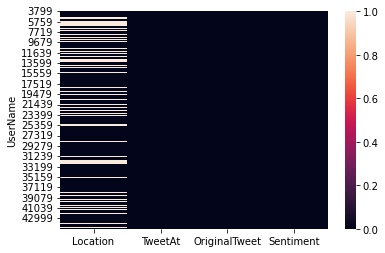

In [8]:
plt.figure()
sns.heatmap(data.isna())

La disposition des données manquantes semble aléatoire.

In [9]:
data.fillna("U",inplace=True)


Pour le moment, afin de faciliter l'étude nous allons drop la colonne location.

In [10]:
data=data.drop("Location",axis=1)

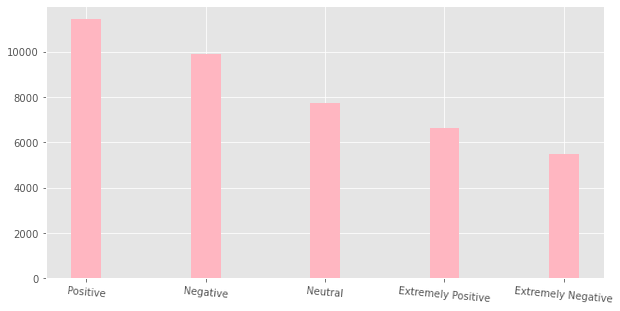

In [11]:
c=data["Sentiment"].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.bar(x=c.index,height=c.values,width=0.25,color="lightpink")
plt.xticks(rotation=-5)
plt.show()

Il n'y a pas de désequilibre majeur entre les classes.

# Impact du temps sur les classes

In [12]:
###### 
data_time=data.copy()
data_time["TweetAt"]=pd.to_datetime(data["TweetAt"],format='%d-%m-%Y')
#changement d'index
data_time=data_time.set_index("TweetAt")
#data_time
#plt.figure()
data_time["Sentiment"].resample("M").agg(sum)

TweetAt
2020-03-31    NeutralPositivePositivePositiveExtremely Negat...
2020-04-30    Extremely NegativeNegativePositiveNeutralExtre...
Freq: M, Name: Sentiment, dtype: object

C:\Users\ranus\anaconda3\envs\Tensorflow\lib\site-packages\pandas\core\indexes\base.py:6393: UserWarning: Parsing '31-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  label = self._maybe_cast_slice_bound(label, side)


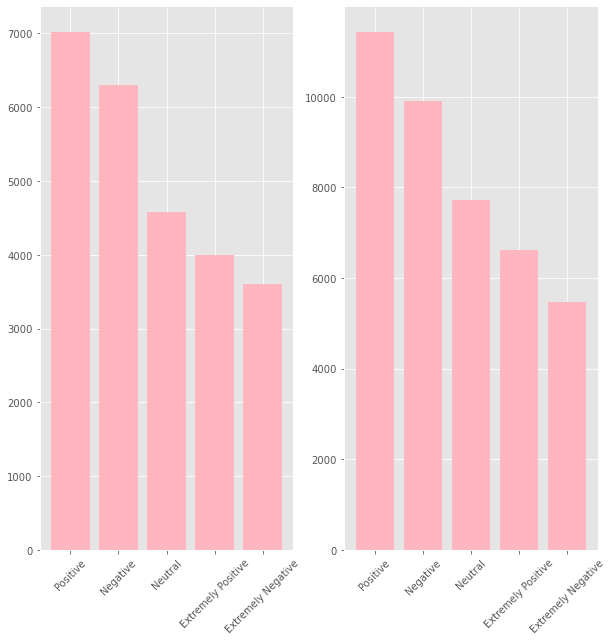

In [13]:
df1=pd.DataFrame(data_time["Sentiment"][:"31-03-2020"].value_counts())
df1["Emotion"]=df1.index
df1=df1.set_index(pd.Index([i for i in range(df1.shape[0])]))
df2=pd.DataFrame(data_time["Sentiment"]["01-04-2020":].value_counts())
df2["Emotion"]=df2.index
df2=df2.set_index(pd.Index([i for i in range(df2.shape[0])]))
#df2
#df2.drop(5,axis=0)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.bar(df1["Emotion"],df1["Sentiment"],color='lightpink')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
plt.bar(df2["Emotion"],df2["Sentiment"],color='lightpink')
plt.xticks(rotation=45)

plt.show()

Le mois de publication des tweet ne semble pas avoir d'impact sur les sentiments.

# data cleaning

In [14]:
target=data["Sentiment"]
data=data.drop("Sentiment",axis=1)
data


,TweetAt,OriginalTweet
UserName,,
3799,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
3800,16-03-2020,advice Talk to your neighbours family to excha...
3801,16-03-2020,Coronavirus Australia: Woolworths to give elde...
3802,16-03-2020,My food stock is not the only one which is emp...
3803,16-03-2020,"Me, ready to go at supermarket during the #COV..."
...,...,...
44951,14-04-2020,Airline pilots offering to stock supermarket s...
44952,14-04-2020,Response to complaint not provided citing COVI...
44953,14-04-2020,You know itÂs getting tough when @KameronWild...


In [15]:

#encodage de la variable cible
encoder=LabelEncoder()
target=pd.DataFrame(encoder.fit_transform(target))



In [16]:
t=time.time()
def traitement1(char):
    char = re.sub("'", "", char) # to avoid removing contractions in english
    char = re.sub("@[A-Za-z0-9_]+","", char)
    char = re.sub("#[A-Za-z0-9_]+","", char)
    char = re.sub(r'http\S+', '', char)
    char = re.sub('[()!?]', ' ', char)
    char = re.sub('\[.*?\]',' ', char)
    char = re.sub("[^a-z0-9]"," ", char)
    return char
def traitement2(liste):
    n=len(liste)
    
    #on definie un liste avec des caractère et des ponctuation
    car=["@","#",".","?","!","...",":"]
    l=[]
    for i in range(n):
        liste[i]=liste[i].lower()
   
    #On retire les éléments présent dans la liste car
    l=[word for word in liste if word not in car]
    
    #filtration des stop words
    liste1=list(filter(lambda word: word not in stopwords.words("english"),l))
    
    #stemmatisation
    #stemmer=nltk.stem.SnowballStemmer('english')
    #liste2=[stemmer.stem(word) for word in liste1]
    
    #lemmatisation
    lemmatizer=nltk.stem.WordNetLemmatizer()
    liste3=[lemmatizer.lemmatize(word) for word in liste1]
    
    return liste3
        


#nltk.download('punkt')
#n=data.shape[0]
#for i in range(n):
#   token=nltk.word_tokenize(data.iloc[i,2])
data["OriginalTweet"]=data['OriginalTweet'].apply(traitement1)
#data
data["OriginalTweet"]=data['OriginalTweet'].apply(nltk.word_tokenize)
#data
# convertie les majuscule en minuscule
data["OriginalTweet"]=data["OriginalTweet"].apply(traitement2)
time.time()-t




230.37288784980774

In [17]:
data

,TweetAt,OriginalTweet
UserName,,
3799,16-03-2020,[]
3800,16-03-2020,"[advice, alk, neighbour, family, exchange, pho..."
3801,16-03-2020,"[oronavirus, ustralia, oolworths, give, elderl..."
3802,16-03-2020,"[food, stock, one, empty, dont, panic, take, n..."
3803,16-03-2020,"[e, ready, go, supermarket, outbreak, ot, para..."
...,...,...
44951,14-04-2020,"[irline, pilot, offering, stock, supermarket, ..."
44952,14-04-2020,"[esponse, complaint, provided, citing, 19, rel..."
44953,14-04-2020,"[ou, know, getting, tough, rationing, toilet, ..."


Nous devons désormais encoder Location et OriginalTweet. Comme les categories des deux variables n'ont pas plus de poids nous utiliserons un encodage du type OneHotEncoder.

In [18]:
#vec=TfidfVectorizer(analyzer="word",max_features=1000)
#X=vec.fit_transform(data["OriginalTweet"])
#X

SyntaxError: invalid syntax (1971107547.py, line 2)

In [19]:
#most_freq_word=[str(ele) for ele in list(df.apply(np.cumsum).iloc[df.shape[0]-1,].sort_values(ascending=False)[0:500,].index)]

#Vectorisons les mots
mlb = MultiLabelBinarizer()
df=pd.DataFrame(mlb.fit_transform(data["OriginalTweet"])) # donne une dataframe de dimension 41152 x 33720


#Nous ne gardons que les 500 mots les plus fréquents
most_freq_word=list(df.apply(np.cumsum).iloc[df.shape[0]-1,].sort_values(ascending=False)[0:500,].index)
df500=df[most_freq_word]

acp=PCA()
result=acp.fit_transform(df500)
col_name=['PC' +str(j) for j in range(result.shape[1])]
result2=pd.DataFrame(result,columns=col_name)
result2

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC490,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499
0,0.024386,-0.361294,-0.093921,-0.147443,-0.241317,-0.157760,-0.118496,-0.117118,-0.000779,-0.079624,...,0.000173,-0.000502,-0.001283,0.000138,-0.001283,-0.002805,-0.003954,0.000069,-0.002315,-0.000481
1,0.041229,-0.240791,0.112734,-0.145714,-0.724125,1.056077,-0.532526,0.076562,0.049779,-0.113259,...,-0.137275,-0.040924,-0.076222,-0.031348,0.001244,0.056336,-0.007200,-0.045220,0.018404,0.012992
2,-0.456620,0.523611,0.136467,-0.309997,-0.403387,0.394899,-0.346752,-0.099057,0.076423,-0.189455,...,-0.030942,-0.071245,0.039503,-0.013704,0.062404,0.010954,0.014432,0.010380,0.014257,0.012591
3,0.075106,-0.300477,0.601383,1.178986,-0.161149,-0.116893,-0.179367,0.006003,0.216311,0.378616,...,0.016048,-0.012227,-0.080118,-0.016013,0.001676,-0.061696,0.016994,0.033194,-0.025064,0.013623
4,0.067774,-0.429707,1.113819,0.818992,0.404035,-0.174347,-0.364689,0.323257,0.196080,0.682624,...,0.021188,-0.019813,0.033007,-0.024051,-0.011452,0.003559,-0.002066,0.010422,-0.022333,0.019372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,-0.467135,0.287877,0.732778,-0.403679,0.441779,-0.295657,-0.295206,0.093375,0.076465,-0.090200,...,0.011783,0.054771,-0.001546,0.012388,-0.006209,0.013574,-0.010311,0.014231,0.007516,-0.008855
41153,-0.502794,0.510612,0.071997,-0.313505,-0.405570,-0.302796,0.189117,-0.105763,-0.378519,0.146324,...,0.005889,-0.016701,0.006834,0.015930,-0.005415,0.012134,0.012374,-0.007605,-0.011518,0.019388
41154,0.094195,-0.361861,0.019698,-0.042255,-0.204996,-0.084349,0.127995,-0.188141,0.251910,0.122949,...,-0.007996,-0.007249,0.012551,0.023305,0.001918,-0.020009,-0.051985,-0.011551,0.003804,-0.007736
41155,0.048458,-0.470029,-0.124111,-0.193675,-0.373626,-0.261017,0.291208,-0.405307,0.963869,-0.154946,...,-0.005888,0.007955,0.016499,-0.012293,-0.007349,-0.007623,0.016302,0.002975,-0.002441,-0.001256


Remarque pour la vectorisation nous aurions pu utiliser **TfidfVectorizer()**

In [ ]:
#df500=df["1"]
#most_freq_word


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
#enc=tf.keras.utils.to_categorical
#ohe=OneHotEncoder()
#count_v=CountVectorizer()
#t=pd.DataFrame({"token":[["Je",'Mange'],["des","gateaux","chocolat"]]})
#n=t.shape[0]
#liste_mots=[]
#for i in range(n):
 #   liste_num=[]
  #  for word in t["token"][i]:
   #     if word not in liste_mots:
    #        liste_mots.append(word)
     #       liste_num.append(liste_mots.index(word))
      #  elif word in liste_mots:
       #     liste_num.append(liste_mots.index(word))
        #t["token"][i]=liste_num
#tf.keras.utils.to_categorical(t)     
            

In [ ]:
##### from sklearn.preprocessing import MultiLabelBinarizer


#l=[[1,2,3],[1,4,5]]
#for i in range(len(l)):
 #   print(pd.get_dummies(l[i]))

Nous allons choisir les composante principaux à garder en fonction de la variance qu'elles expliquent. Nous allons fxer le seuil à 80%

In [20]:
evr=pd.DataFrame([np.cumsum(acp.explained_variance_ratio_)>0.8])

evr.T.value_counts()

evr

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


Nous allons garder les premières 258 composantes principaux.

In [21]:
pc=["PC"+str(i) for i in range(258)]

result2=result2.set_index(data.index)
copi=data.copy()
#data=data.drop("OriginalTweet",axis=1)
copi=copi.join(result2[pc])
copi
#data

,TweetAt,OriginalTweet,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255,PC256,PC257
UserName,,,,,,,,,,,,,,,,,,,,,
3799,16-03-2020,[],0.024386,-0.361294,-0.093921,-0.147443,-0.241317,-0.157760,-0.118496,-0.117118,...,0.001448,-0.009604,0.001745,-0.013232,-0.003194,0.001482,-0.004174,-0.001511,0.004214,-0.003812
3800,16-03-2020,"[advice, alk, neighbour, family, exchange, pho...",0.041229,-0.240791,0.112734,-0.145714,-0.724125,1.056077,-0.532526,0.076562,...,0.009497,-0.113635,-0.137407,-0.079714,-0.260150,0.245651,0.052298,0.031477,-0.146876,-0.168763
3801,16-03-2020,"[oronavirus, ustralia, oolworths, give, elderl...",-0.456620,0.523611,0.136467,-0.309997,-0.403387,0.394899,-0.346752,-0.099057,...,-0.001370,-0.040234,-0.087896,-0.013071,0.041430,-0.110210,-0.070965,-0.121925,0.033620,-0.091691
3802,16-03-2020,"[food, stock, one, empty, dont, panic, take, n...",0.075106,-0.300477,0.601383,1.178986,-0.161149,-0.116893,-0.179367,0.006003,...,0.137939,-0.133469,0.156655,-0.118013,-0.051140,0.018668,0.053923,-0.038504,0.039163,-0.163676
3803,16-03-2020,"[e, ready, go, supermarket, outbreak, ot, para...",0.067774,-0.429707,1.113819,0.818992,0.404035,-0.174347,-0.364689,0.323257,...,0.093765,-0.069293,0.174490,-0.195608,-0.073965,0.001437,-0.087933,-0.084528,-0.022058,-0.058411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44951,14-04-2020,"[irline, pilot, offering, stock, supermarket, ...",-0.467135,0.287877,0.732778,-0.403679,0.441779,-0.295657,-0.295206,0.093375,...,-0.002559,0.015041,-0.052854,-0.005416,0.007739,-0.069265,0.024519,0.050905,0.042635,0.029217
44952,14-04-2020,"[esponse, complaint, provided, citing, 19, rel...",-0.502794,0.510612,0.071997,-0.313505,-0.405570,-0.302796,0.189117,-0.105763,...,0.002733,-0.016743,-0.000751,-0.010855,-0.080213,0.002656,0.007160,0.022028,-0.000978,0.001610
44953,14-04-2020,"[ou, know, getting, tough, rationing, toilet, ...",0.094195,-0.361861,0.019698,-0.042255,-0.204996,-0.084349,0.127995,-0.188141,...,-0.010584,-0.034218,-0.000039,-0.040662,-0.013560,-0.008060,-0.003793,-0.014341,0.003446,-0.016795


In [22]:
data_train,data_test,target_train,target_test=train_test_split(data,target,test_size=0.2)


Essayons de regler les hyperparametres du randomforest.

In [37]:
#Si les classes des deséquilibrées, on aurait pu utiliser StratifiedKfold.
param_grid={"max_depth":[2,3],"min_samples_leaf":[1,2,3]}
cv = KFold(n_splits=3)
rf=RandomForestClassifier()

gridsearch= GridSearchCV(estimator=rf, param_grid=param_grid,cv=cv)

gridsearch.fit(data,target)

print("Best score:"+str(gridsearch.best_scor_))
print('Best Parameters:'+str(gridsearch.best_params_))




C:\Users\ranus\anaconda3\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ranus\anaconda3\envs\Tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ranus\anaconda3\envs\Tensorflow\lib\site-packages\sklearn\ensemble\_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "C:\Users\ranus\anaconda3\envs\Tensorflow\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y

ValueError: could not convert string to float: '16-03-2020'

In [ ]:
y_bar=gridsearch.predict(data_test)

#matrice de confusion
cm1=confusion_matrix(y_test,y_bar)


#visualisation de la matrice de confusion avec une carte de chaleur
cmd=ConfusionMatrixDisplay(cm1)
cmd.plot()
cmd.ax_.set(xlabel='rf_predict',ylabel='true_target')


# Prediction avec t-sne

# Prediction avec un RNN

In [ ]:
model=keras.Senquential()
model.add()

* roc= première bissectrice<=> modele sort les label aléatoirement 
* roc + concave ou l'air sous la courbetres grand <=> bonne méthode
* roc sert a comparer localement.